In [0]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn

def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
   
 
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        #iteration
        it = nditer(self.activation_map, flags=['multi_index'])# causes a multi-index, or a tuple of indices with one per iteration dimension, to be tracked.
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        # print("self.weights.shape[0]",self.weights.shape[0]," self.weights.shape[1]",self.weights.shape[1]," @@ % ",self.weights.shape[2])
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        # print(it.multi_index)
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                # print(" it.multi_index[0]-1 ",it.multi_index[0]-1," it.multi_index[0]+2 : ",it.multi_index[0]+2)
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
                # print("_______",um)
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap



In [0]:
cd Desktop

C:\Users\Anas Badawi\Desktop


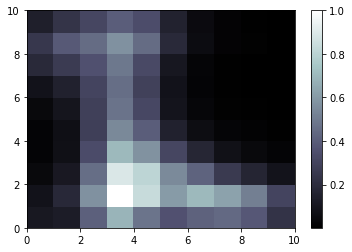

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances


dataset = pd.read_csv('breast-cancer-unsupervised-ad.csv')


X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (0, 1))
# X = sc.fit_transform(X)
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (0, 1))
# X = sc.fit_transform(X)

som = MiniSom(x =10, y =10, input_len = X.shape[1], sigma = 1, learning_rate = 0.5)
som.random_weights_init(X)
som.train_batch(data = X, num_iteration = 100)

cluster = som.distance_map().T

kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(cluster)
labels = kmeans.predict(cluster)
centroids = kmeans.cluster_centers_
# print (centroids)

dists = euclidean_distances(kmeans.cluster_centers_)
tri_dists = dists[np.triu_indices(2)]
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()

# print (max_dist)


from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)    
colorbar()
markers={}
markers["o"] = 'o'
markers["n"] = 's'  
colors={}
colors["o"] = 'r'
colors["n"] = 'g'
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0]+0.5 ,
         w[1] +0.5,
#          markers[y[i]],
#          markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()


